### Contextualização

Utilizar dois datasets contendo informações relativas a solicitações de empréstimos (atuais e anteriores) para viabilizar a construção de insights que comporão políticas de negócio com o objetivo de mitigar a taxa de inadimplência prejudicando o mínimo possível os índices de aprovação.

**OBJETIVOS:**

          *   CENÁRIO 01: Redução da taxa de inadimplência em 10%;
          *   CENÁRIO 02: Redução da taxa de inadimplência em 20%;



## Importação de pacotes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import shapiro

warnings.filterwarnings("ignore")

## Importação das bases de dados

Hospedei os arquivos .csv em meu repositório do GitHub para facilitar o manuseio. Portanto, importando-os de lá:

In [ ]:
url = ['https://raw.githubusercontent.com/Arnaldo-Bastos/Inadimp_Case/main/application_data_localiza_reduzido.csv'
       ,'https://raw.githubusercontent.com/Arnaldo-Bastos/Inadimp_Case/main/previous_application_localiza_reduzido.csv'
      ]
df_cur = pd.read_csv(url[0], delimiter = ',')
df_prev = pd.read_csv(url[1], delimiter = ',')

## ETL (Extract, Transform and Load) dos datasets

###   Dataset dos empréstimos atuais

Verificando a situação dos valores vazios e/ou nulos na base

In [ ]:
print((df_cur.isnull().sum() / len(df_cur)) * 100)

SK_ID_CURR                 0.000000
TARGET                     0.000000
CODE_GENDER                0.000000
FLAG_OWN_CAR               0.000000
CNT_CHILDREN               0.000000
AMT_INCOME_TOTAL           0.000000
AMT_CREDIT                 0.000000
AMT_ANNUITY                0.004336
NAME_INCOME_TYPE           0.000000
NAME_HOUSING_TYPE          0.000000
DAYS_BIRTH                 0.000000
DAYS_REGISTRATION          0.000000
DAYS_ID_PUBLISH            0.000000
OCCUPATION_TYPE           31.414697
CNT_FAM_MEMBERS            0.001084
EXT_SOURCE_1              56.506563
EXT_SOURCE_3              19.649225
DAYS_LAST_PHONE_CHANGE     0.000000
dtype: float64


Como as variáveis 'AMT_ANNUITY' e 'CNT_FAM_MEMBERS' possuem um percentual muito baixo de valores nulos, vamos deletar esses registros

In [ ]:
df_cur.dropna(subset = ['AMT_ANNUITY','CNT_FAM_MEMBERS'], inplace = True)

Basicamente temos 3 colunas ('OCCUPATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_3') com percentuais significativos de valores nulos. Porém, antes de realizarmos qualquer tratativa quanto a isso, vamos verificar as distribuições desses dados:

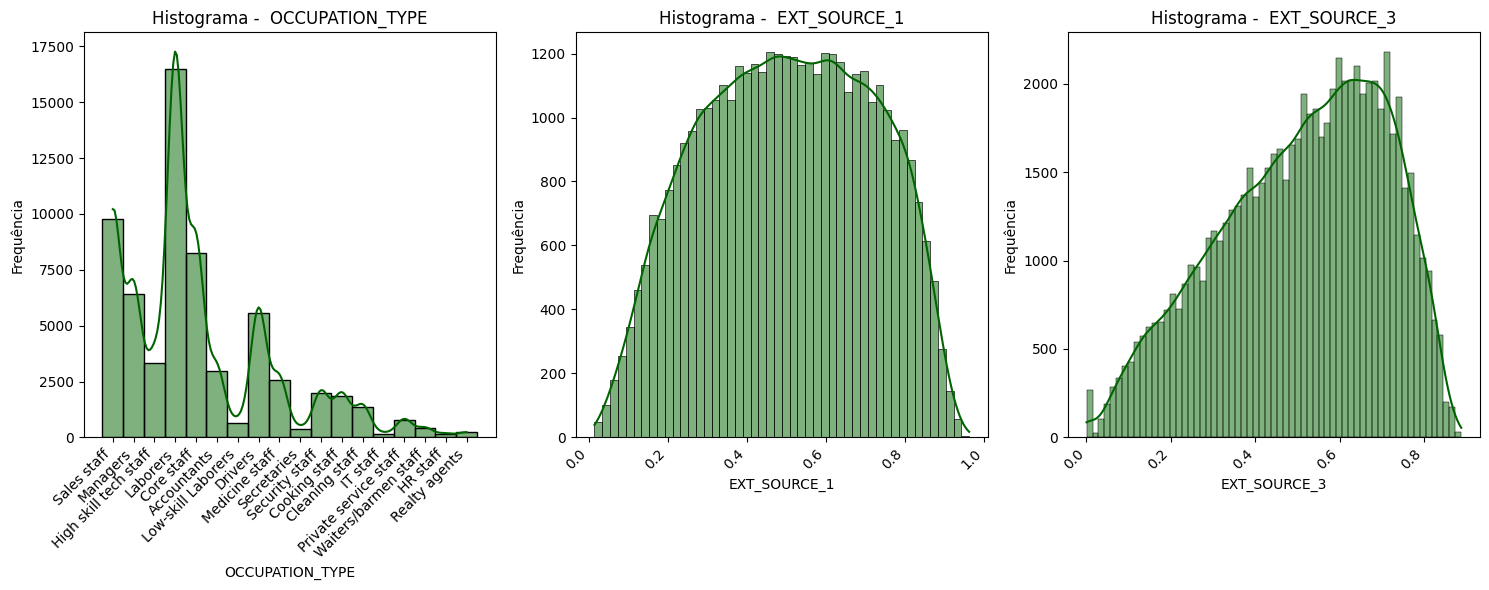

In [ ]:
variables = ['OCCUPATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_3']

fig, axes = plt.subplots(1, 3, figsize = (15, 6)) # Ajusta o tamanho da figura para melhor visualização
for i, col in enumerate(variables):
    sns.histplot(df_cur[col].dropna(), kde = True, ax = axes[i], color = '#006400')
    axes[i].set_title(f'Histograma -  {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()


Analisando visualmente, parece que a variável 'EXT_SOURCE_1' possível uma distribuição normal (formato de gaussiana), porém vamos confirmar estatisticamente através de um teste adequado:

In [ ]:
stat, p = shapiro(df_cur['EXT_SOURCE_1'].dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Utilizando 95% de intervalo de confiança
alpha = 0.05
if p > alpha:
    print('Amostra parece Gaussiana (falha ao rejeitar H0)')
else:
    print('Amostra não parece Gaussiana (rejeita H0)')


Statistics=0.978, p=0.000
Amostra não parece Gaussiana (rejeita H0)


Insights:

*   A variável '**EXT_SOURCE_3**' possui uma distribuição nitidamente assimétrica, como se trata de uma variável numérica contínua uma estratégia interessante será preencher os valores nulos com uma interpolação linear com os valores vizinhos pois, dessa forma não alteraremos o formato da distribuição evitando distorção nos dados;

*   Apesar de em 1ª momento a variável '**EXT_SOURCE_1**' aparentar uma distribuição normal, validamos através do teste estatístico que também trata-se de uma distribuição assimétrica, portanto utilizaremos a mesma estratégia da 'EXT_SOURCE_3';

*   Para a variável '**OCCUPATION_TYPE**' não há um formato definido de distribuição. O que identificamos são picos de concentração em algumas ocupações, portanto aqui preencheremos os valores vazios com a ocupação mais observada, no caso "Laborers", também para não distorcer a distribuição.





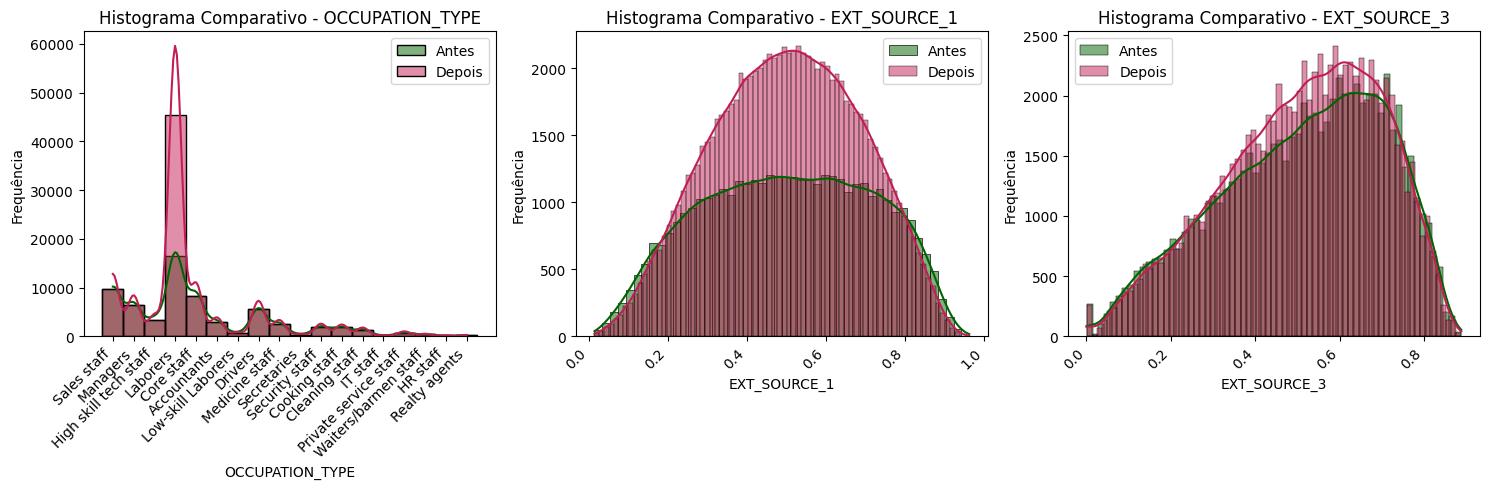

In [ ]:
df_cur_antigo = df_cur.copy()

df_cur['EXT_SOURCE_1'] = df_cur['EXT_SOURCE_1'].fillna(df_cur['EXT_SOURCE_1'].interpolate(method = 'linear'))
df_cur['EXT_SOURCE_3'] = df_cur['EXT_SOURCE_3'].fillna(df_cur['EXT_SOURCE_3'].interpolate(method = 'linear'))
df_cur['OCCUPATION_TYPE'] = df_cur['OCCUPATION_TYPE'].fillna(df_cur['OCCUPATION_TYPE'].mode()[0])

fig, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, col in enumerate(variables):
    sns.histplot(df_cur_antigo[col].dropna(), kde = True, color = '#006400', label = 'Antes', ax = axes[i])
    sns.histplot(df_cur[col].dropna(), kde = True, color = '#c21e56', label = 'Depois', ax = axes[i])
    axes[i].set_title(f'Histograma Comparativo - {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha = 'right')
    axes[i].legend()

plt.tight_layout()
plt.show()

Portanto, vemos que a estratégia foi adequada devido a alta sobreposição dos histogramas mostrando que os preenchimentos não alteraram as distribuições.

Por fim, vamos promover nesse dataset tratativas finais (alteração nome de algumas colunas, conversão de granularidade temporal, remoção de sinal negativo nas colunas) apenas para facilitar interpretação:

In [ ]:
for col in df_cur.columns:
    if 'DAYS' in col:
        df_cur[col] = df_cur[col].abs()

for col in df_prev.columns:
    if 'DAYS' in col:
        df_prev[col] = df_prev[col].abs()

df_cur['DAYS_BIRTH'] = (df_cur['DAYS_BIRTH'] / 365).round(0).astype(int)
df_cur['DAYS_REGISTRATION'] = (df_cur['DAYS_REGISTRATION'] / 30).round(0).astype(int)
df_cur['DAYS_ID_PUBLISH'] = (df_cur['DAYS_ID_PUBLISH'] / 30).round(0).astype(int)
df_cur['DAYS_LAST_PHONE_CHANGE'] = (df_cur['DAYS_LAST_PHONE_CHANGE'] / 30).round(0).astype(int)

df_cur.rename(columns = {
                          'DAYS_BIRTH': 'AGE'
                          , 'DAYS_REGISTRATION': 'MONTHS_REGISTRATION'
                          , 'DAYS_ID_PUBLISH': 'MONTHS_ID_PUBLISH'
                          , 'DAYS_LAST_PHONE_CHANGE': 'MONTHS_LAST_PHONE_CHANGE'}
              , inplace = True)


###   Dataset dos empréstimos anteriores

Verificando a situação dos valores vazios e/ou nulos na base

In [ ]:
print((df_prev.isnull().sum() / len(df_prev)) * 100)

SK_ID_PREV                    0.000000
SK_ID_CURR                    0.000000
NAME_CONTRACT_TYPE            0.000000
AMT_ANNUITY                  22.272604
AMT_APPLICATION               0.000000
AMT_CREDIT                    0.000000
CODE_REJECT_REASON            0.000000
DAYS_FIRST_DRAWING           40.354526
DAYS_FIRST_DUE               40.354526
DAYS_LAST_DUE_1ST_VERSION    40.354526
DAYS_LAST_DUE                40.354526
DAYS_TERMINATION             40.354526
dtype: float64


Aqui diferentemente do outro dataset, temos mais colunas e com maior percentual de valores nulos. Vamos primeiro observar o comportamento dessas 6 variáveis:

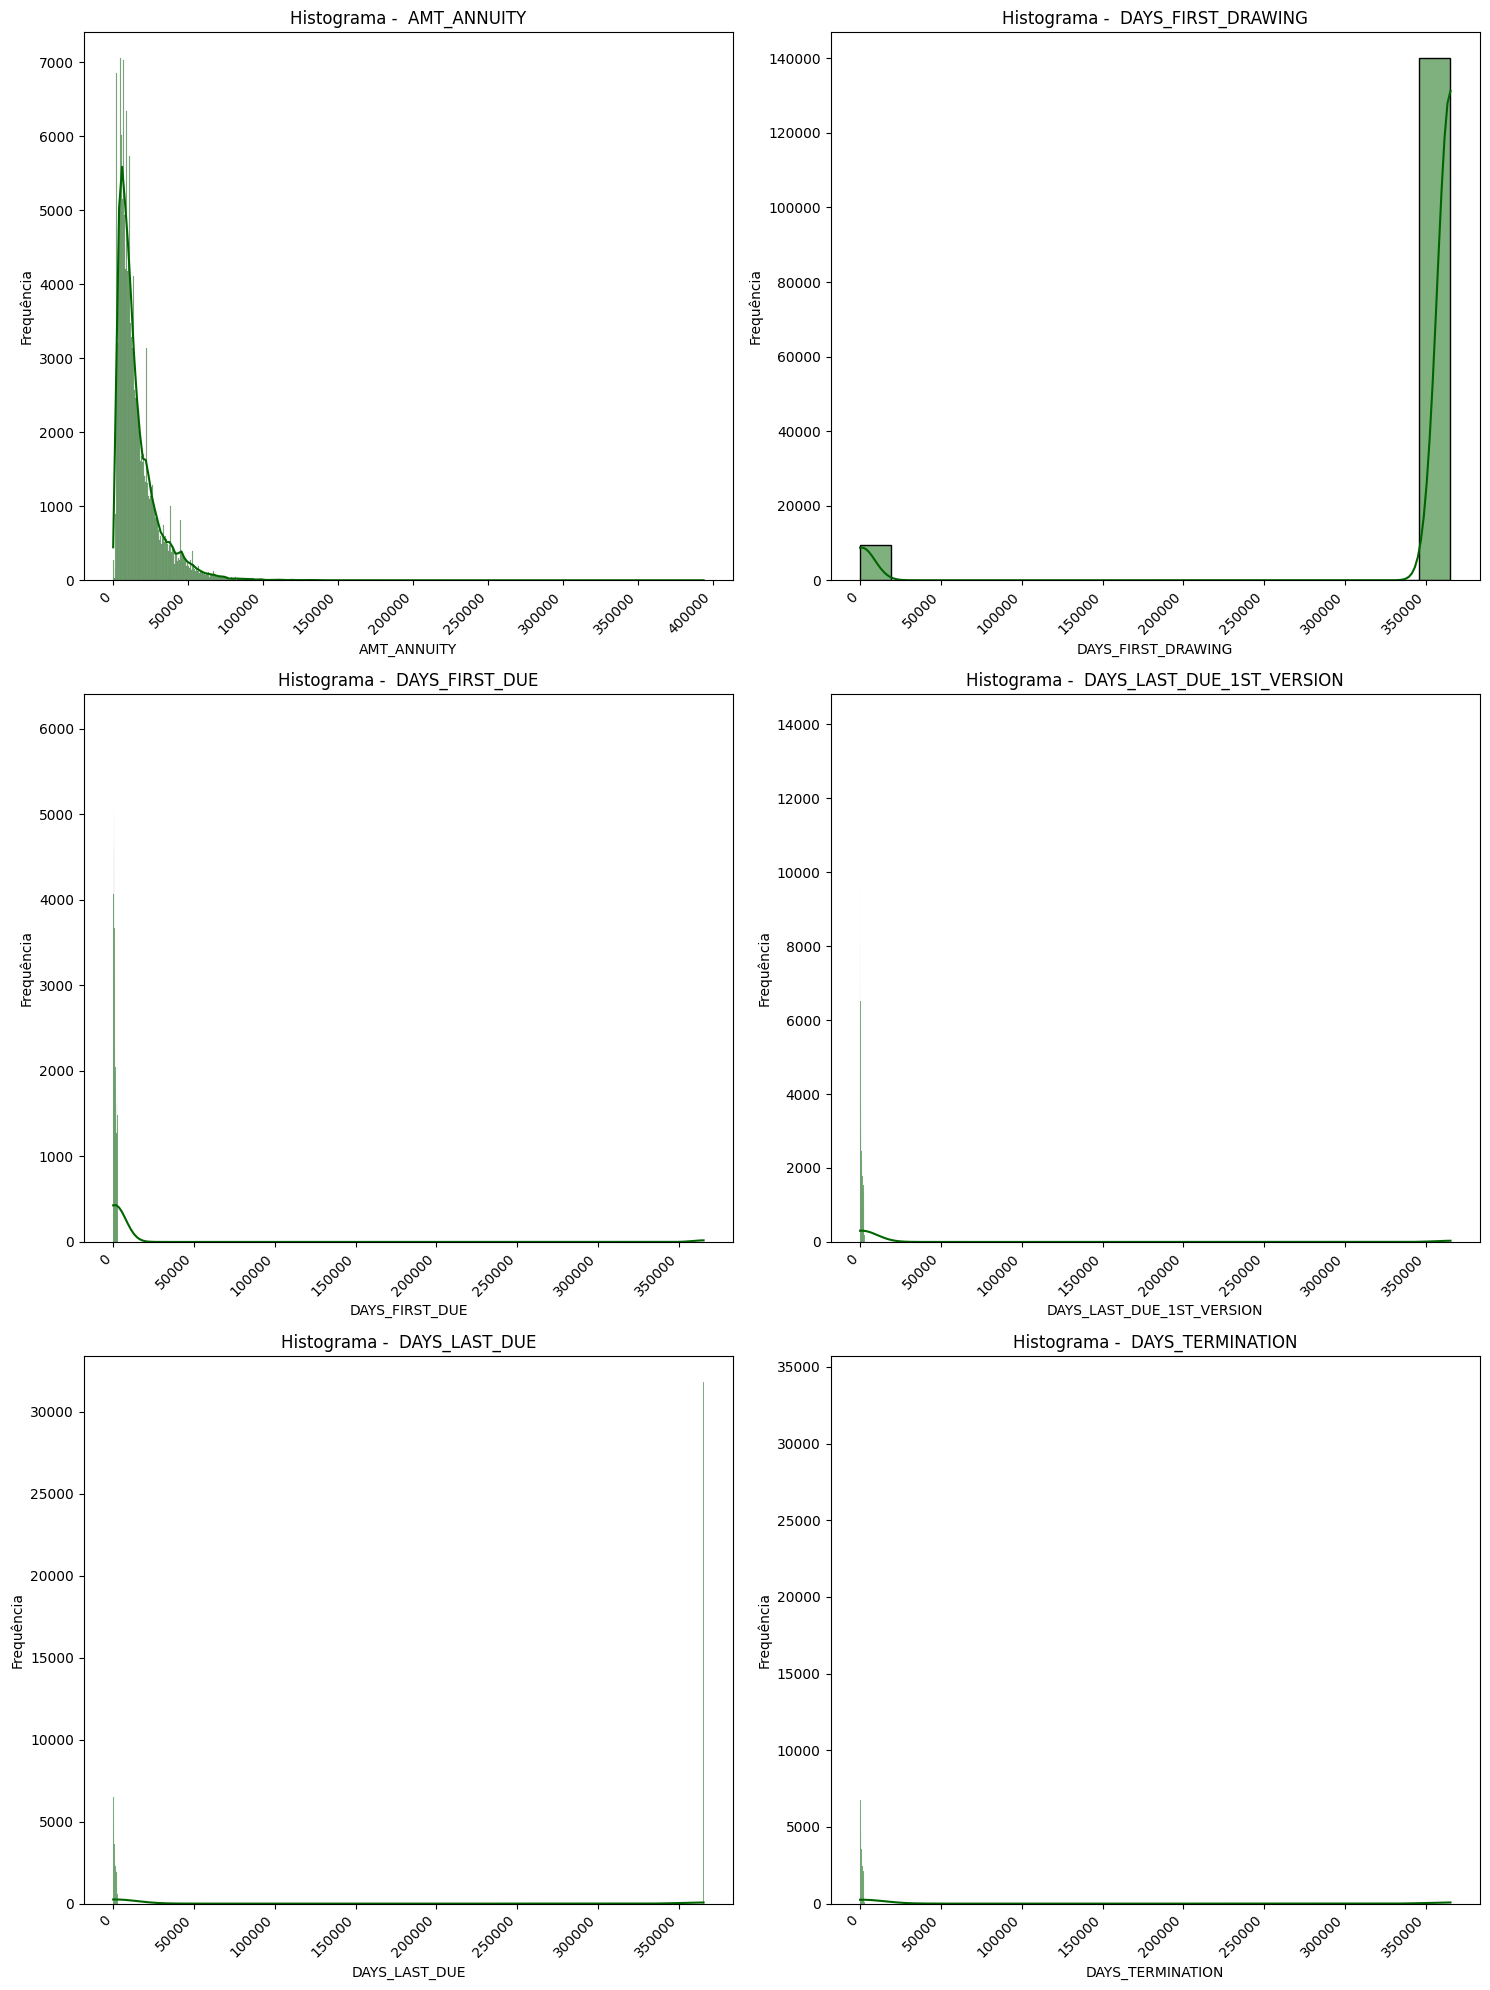

In [ ]:
variables = ['AMT_ANNUITY','DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

fig, axes = plt.subplots(3, 2, figsize = (15,20))

# Flatten the axes array to iterate through subplots correctly
axes = axes.flatten()

for i, col in enumerate(variables):
    sns.histplot(df_prev[col], kde = True, ax = axes[i], color = '#006400') # Now axes[i] refers to a single subplot
    axes[i].set_title(f'Histograma -  {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

Primeiramente, para a coluna referente à anuidade do empréstimo tomado, vamos seguir a mesma estratégia adotada na base atual, ou seja, preencher os valores faltantes através de interpolação:

In [ ]:
df_prev['AMT_ANNUITY'] = df_prev['AMT_ANNUITY'].interpolate(method = 'linear')

É possível notar que em todas as colunas relativas a diferença temporal, há uma elevada ocorrência (e bem estranha) do valor "365243". Como é um comportamento bem atípico muito provavelmente deve se tratar de um erro de digitação/inserção na base.

Vamos excluir primeiramente os registros da coluna DAYS_FIRST_DRAWING e observar o comportamento das demais, ao invés de remover tudo de uma vez:

In [ ]:
df_prev.dropna(subset = ['DAYS_FIRST_DRAWING'], inplace = True)

In [ ]:
print((df_prev.isnull().sum() / len(df_prev)) * 100)


SK_ID_PREV                   0.0
SK_ID_CURR                   0.0
NAME_CONTRACT_TYPE           0.0
AMT_ANNUITY                  0.0
AMT_APPLICATION              0.0
AMT_CREDIT                   0.0
CODE_REJECT_REASON           0.0
DAYS_FIRST_DRAWING           0.0
DAYS_FIRST_DUE               0.0
DAYS_LAST_DUE_1ST_VERSION    0.0
DAYS_LAST_DUE                0.0
DAYS_TERMINATION             0.0
dtype: float64


In [ ]:
df_prev.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,1.494310e+05,149431.000000,149431.000000,1.494310e+05,1.494310e+05,149431.000000,149431.000000,149431.000000,149431.000000,149431.000000
mean,1.903370e+06,278038.388266,14415.511357,1.728865e+05,1.939802e+05,342220.100488,15972.582215,35268.228273,78551.868869,83942.446353
std,5.350142e+05,102743.632361,13499.243031,2.421336e+05,2.622636e+05,88629.793532,72064.318843,106554.772661,149114.601301,152769.025800
min,1.000001e+06,100007.000000,0.000000,0.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000
25%,1.434518e+06,189020.000000,5881.117500,4.500000e+04,4.722075e+04,365243.000000,475.000000,255.000000,457.000000,450.000000
50%,1.896537e+06,277834.000000,10209.960000,9.000000e+04,9.955800e+04,365243.000000,919.000000,739.000000,1156.000000,1171.000000
75%,2.366780e+06,366979.500000,17947.575000,1.825380e+05,2.160810e+05,365243.000000,1821.000000,1735.000000,2429.000000,2512.000000
max,2.843499e+06,456255.000000,393868.665000,4.185000e+06,4.050000e+06,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000


A coluna DAYS_FIRST_DRAWING ainda parece ser um problema, pelas estatísticas do dataframe vemos que praticamente todos seus valores residem na observação estranha ("365243"), portanto precisaremos deletá-la.

Além disso, para as demais colunas temporais, vamos remover os registros com esse valor:

In [ ]:
df_prev.drop(columns = ['DAYS_FIRST_DRAWING'], inplace = True)

columns_to_clean = ['DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
for col in columns_to_clean:
    df_prev = df_prev[df_prev[col] != 365243]


Vejamos agora como ficaram as distribuições das variáveis com essa estatégia:

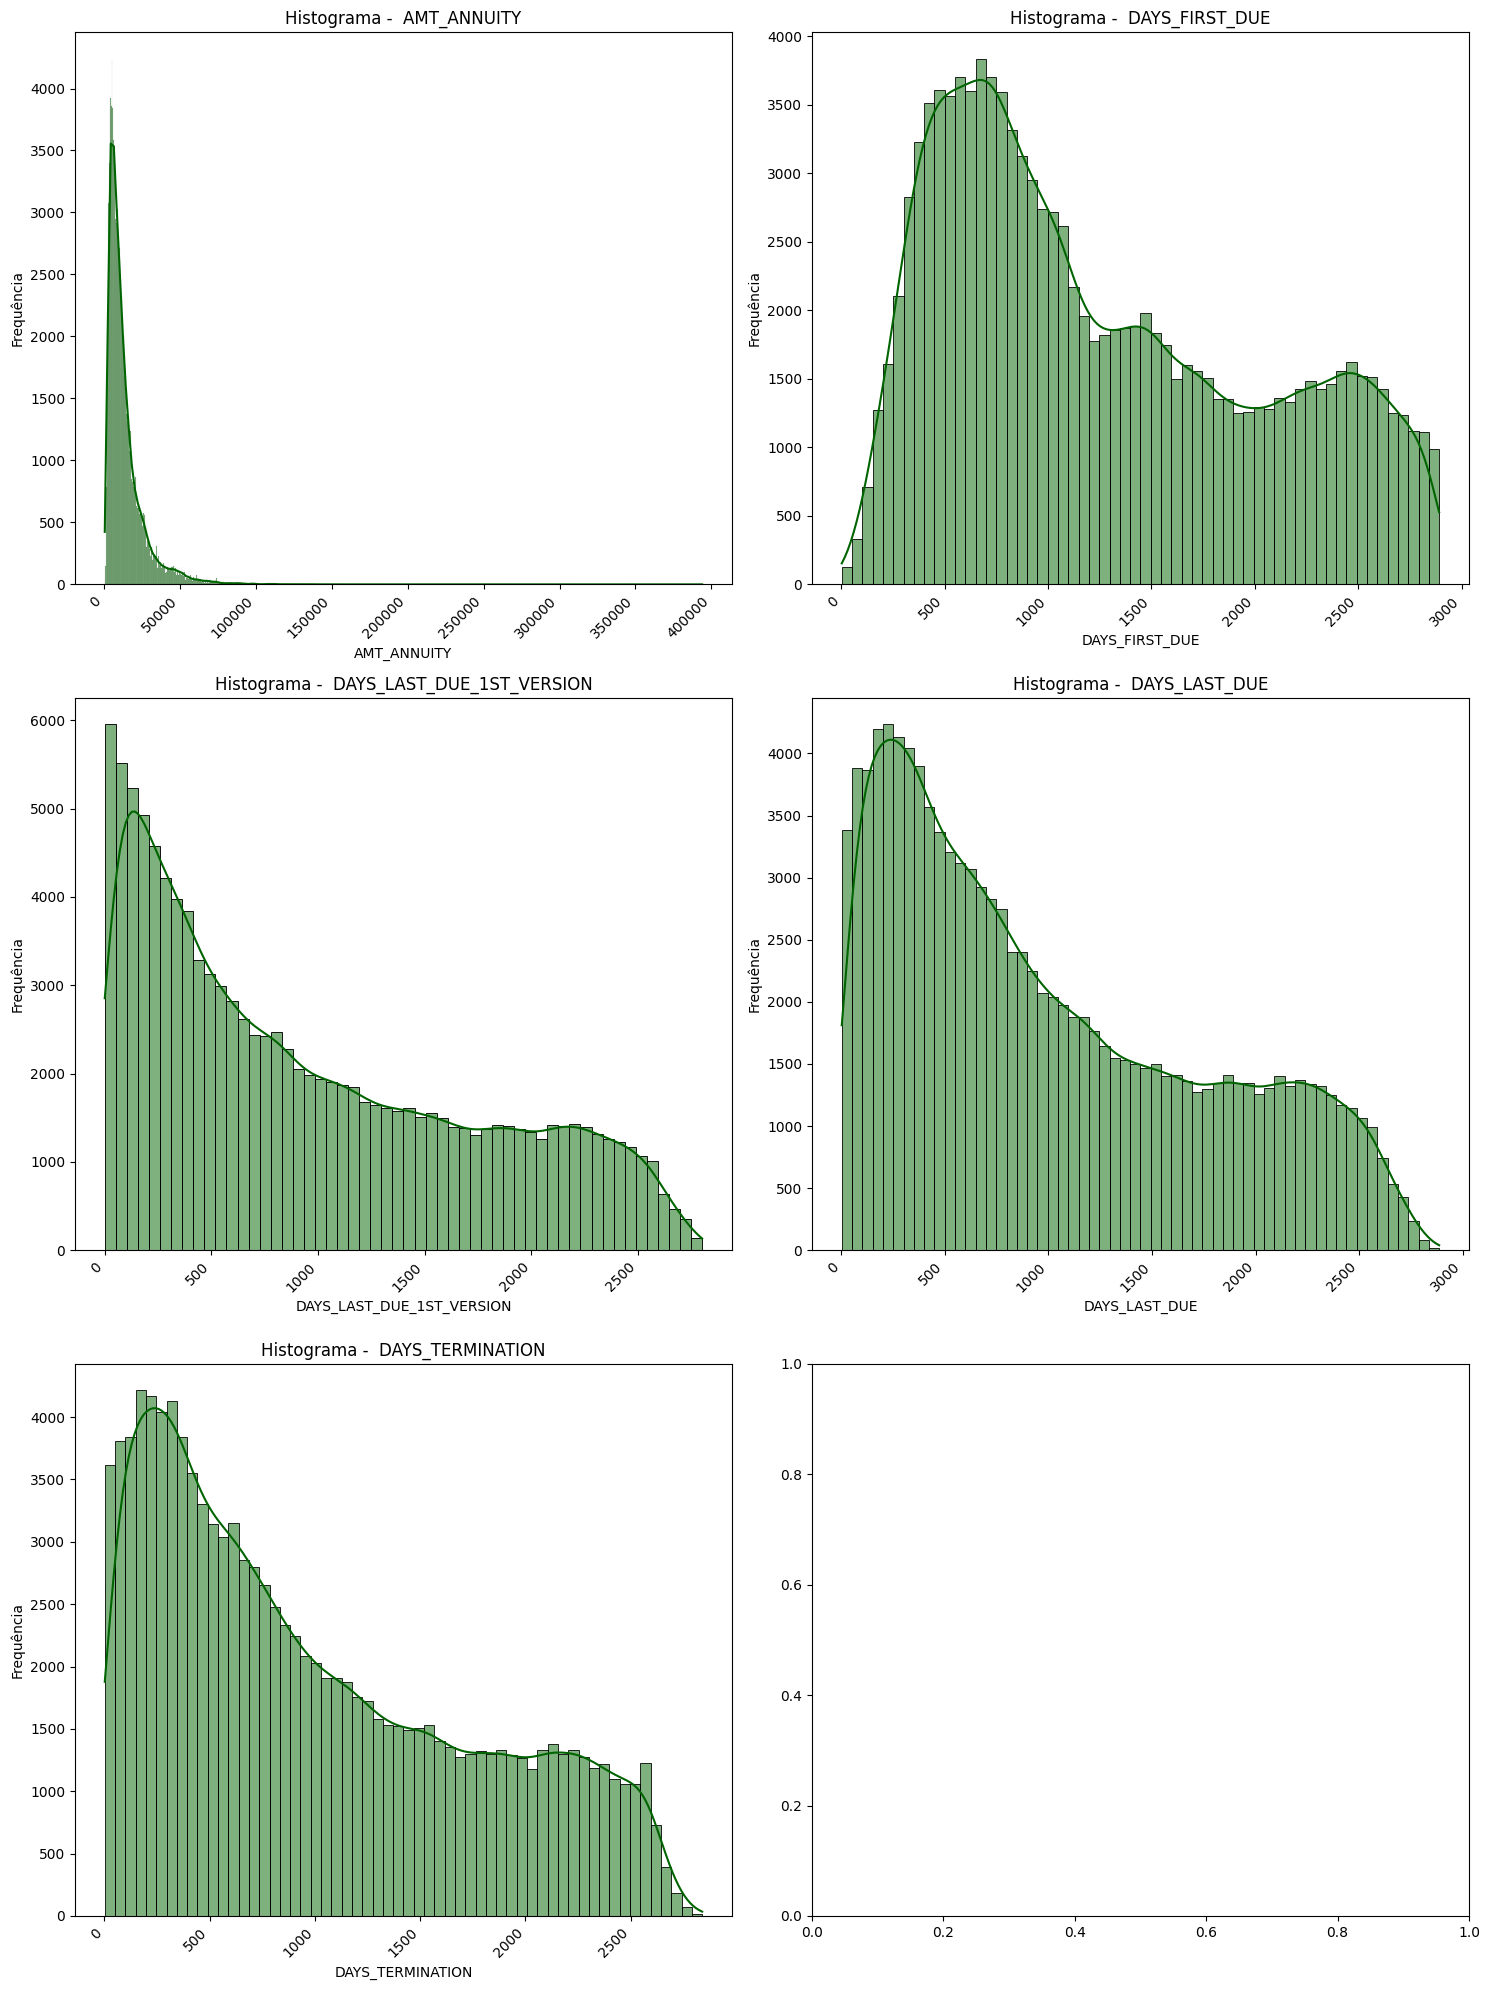

In [ ]:
variables = ['AMT_ANNUITY','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

fig, axes = plt.subplots(3, 2, figsize = (15,20))

axes = axes.flatten()

for i, col in enumerate(variables):
    sns.histplot(df_prev[col], kde = True, ax = axes[i], color = '#006400')
    axes[i].set_title(f'Histograma -  {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [ ]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113503 entries, 0 to 250531
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 113503 non-null  int64  
 1   SK_ID_CURR                 113503 non-null  int64  
 2   NAME_CONTRACT_TYPE         113503 non-null  object 
 3   AMT_ANNUITY                113503 non-null  float64
 4   AMT_APPLICATION            113503 non-null  float64
 5   AMT_CREDIT                 113503 non-null  float64
 6   CODE_REJECT_REASON         113503 non-null  object 
 7   DAYS_FIRST_DUE             113503 non-null  float64
 8   DAYS_LAST_DUE_1ST_VERSION  113503 non-null  float64
 9   DAYS_LAST_DUE              113503 non-null  float64
 10  DAYS_TERMINATION           113503 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 10.4+ MB


Assim como no dataset anterior, vamos por fim promover algumas mudanças de nomenclaturas de colunas bem como alterar a granularidade de diferença temporal para facilitar a interpretação:

In [ ]:
df_prev['DAYS_FIRST_DUE'] = abs(df_prev['DAYS_FIRST_DUE'] / 30).round(0)
df_prev['DAYS_LAST_DUE_1ST_VERSION'] = abs(df_prev['DAYS_LAST_DUE_1ST_VERSION'] / 30).round(0)
df_prev['DAYS_LAST_DUE'] = abs(df_prev['DAYS_LAST_DUE'] / 30).round(0)
df_prev['DAYS_TERMINATION'] = abs(df_prev['DAYS_TERMINATION'] / 30).round(0)

df_prev.rename(columns = {
                          'DAYS_FIRST_DRAWING': 'MONTHS_FIRST_DRAWING'
                          ,'DAYS_FIRST_DUE': 'MONTHS_FIRST_DUE'
                          ,'DAYS_LAST_DUE_1ST_VERSION': 'MONTHS_LAST_DUE_1ST_VERSION'
                          ,'DAYS_LAST_DUE': 'MONTHS_LAST_DUE'
                          ,'DAYS_TERMINATION': 'MONTHS_TERMINATION'
                        }
              , inplace = True)

## EDA (Exploratory Data Analysis)

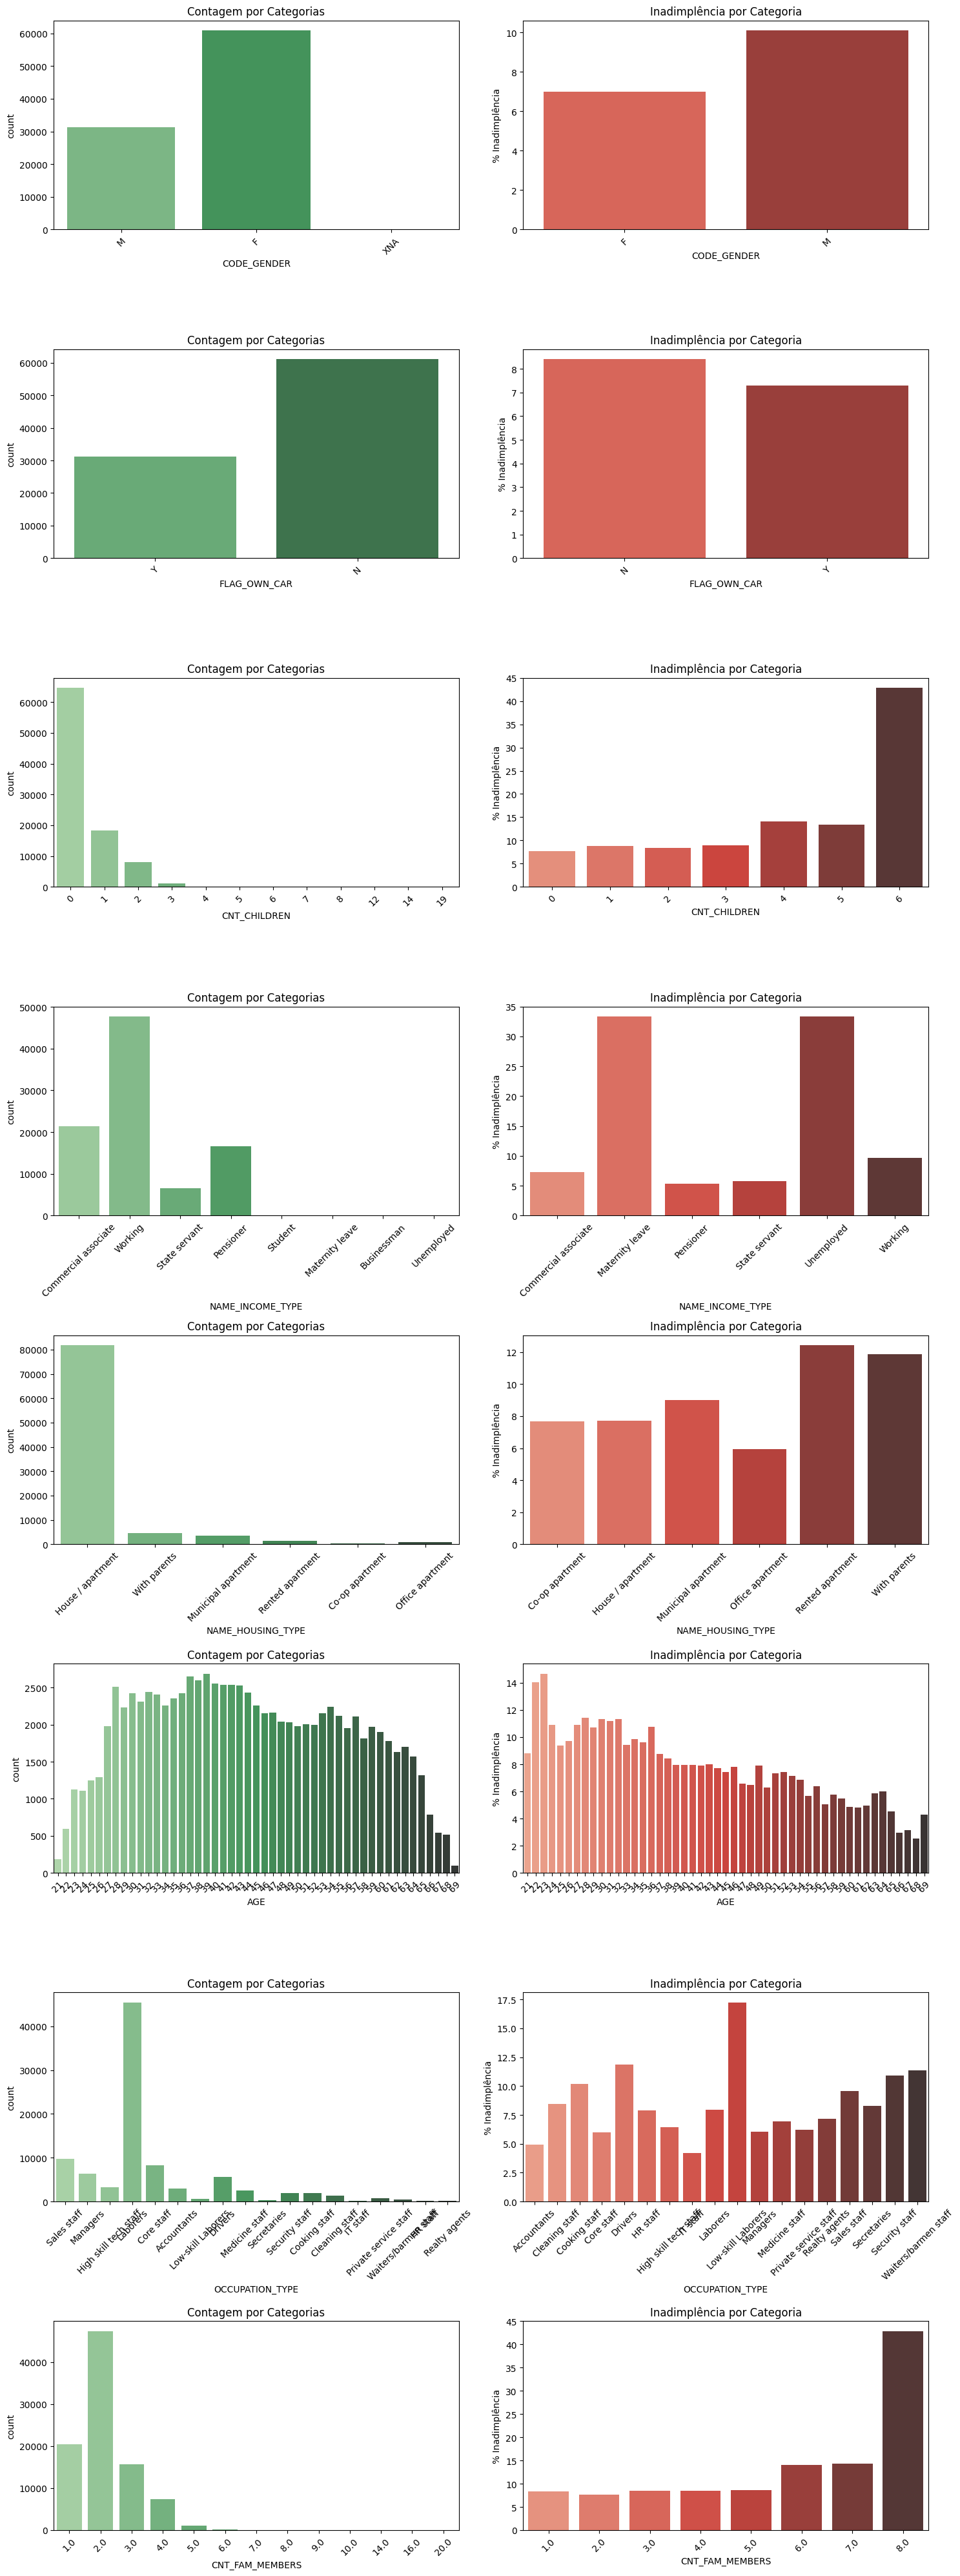

In [ ]:
variables = ['CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'AGE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

fig, axes = plt.subplots(len(variables), 2, figsize = (15, 5 * len(variables)))

for i, var in enumerate(variables):

    sns.countplot(data = df_cur, x = var, ax = axes[i, 0], palette = 'Greens_d')
    axes[i, 0].set_title('Contagem por Categorias')
    axes[i, 0].tick_params(axis = 'x', rotation = 45)


    target_1_percentage = df_cur.groupby(var)['TARGET'].value_counts(normalize = True).mul(100).rename('percent').reset_index()
    target_1_percentage = target_1_percentage[target_1_percentage['TARGET'] == 1]

    sns.barplot(data = target_1_percentage, x = var, y = 'percent', ax = axes[i, 1], palette = 'Reds_d')
    axes[i, 1].set_title('Inadimplência por Categoria')
    axes[i, 1].set_ylabel('% Inadimplência')
    axes[i, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()

Insights:

*   **CODE_GENDER:** não há diferenças tão significativas entre os patamares de inadimplência entre os 2 gêneros, mesmo observando que a frequência dos homens é cerca de metade das mulheres e ainda sim tendem a ser mais inadimplentes;

*   **FLAG_OWN_CAR:** aqui também não vemos muita interferência na variável target o fato da pessoa possuir ou não um veículo e, também com observação análoga à variável de gênero;

*   **CNT_CHILDREN:** quanto mais filhos o proponente possui, maior a tendência de ser um cliente inadimplente. Poderíamos dizer que mais de 2 filhos o risco se torna muito alto, ainda mais que a frequência desses casos é baixíssima;

*   **NAME_INCOME_TYPE:** ocupações com alta percepção de estabilidade (servidores públicos e pensionistas), ou seja, onde há alta previsibilidade de proventos, tendem a ter baixíssimas taxas de inadimplência. Já para situações onde o proponente esteja desempregado ou em licença maternidade, a incerteza sobre a regularidade de renda influencia bastante no alto índice de inadimplência para essas categorias;

*   **NAME_HOUSING_TYPE:** predominantemente os proponentes possuem uma moradia própria (casa ou apto). Situações mais instáveis de moradia (morando de favor com algum membro da família ou em locais cedidos por assistência social) tendem a refletir insuficiência de condições financeiras e consequentemente refletem em maiores taxas de inadimplência. Já a questão das residências alugadas provavelmente sofrem com o fato dessa despesa representar uma fatia considerável (e, prioritária) do orçamento do solicitante e, portanto diminuem a proporção de recursos financeiros para garantir os pagamentos de um empréstimo;

*   **AGE:** quanto mais jovem mais propenso a ser inadimplente, esse é o comportamento observado aqui. Sobretudo na faixa 20-25 onde a PEA (População Economicamente Ativa) é menor. Outro ponto interessante é que na faixa de maior frequência (37-45) observa-se uma certa estabilidade dos níveis de inadimplência;

*   **OCCUPATION_TYPE:** dois outliers sobressaltam aos olhos pois, por um lado temos alta incidência de trabalhadores qualificados (provavelmente bem remunerados) e com a mais baixa taxa de inadimplência e, na outra ponta uma quantidade não tão expressiva de solicitantes com profissões de menor qualificação técnica porém com alto índice de inadimplência;

*   **CNT_FAM_MEMBERS:** famílias menores tendem a ser mais adimplentes. Mais do que 3 membros aumenta a chance de nem todos serem contribuintes com a renda da família (filhos, parentes desempregados, etc...) e das despesas essenciais serem mais altas, comprometendo o orçamento e trazendo maior risco em uma situação de empréstimo.


Com base nos insights acima, as variáveis com maior potencial de nos ajudar a discriminar o evento inadimplência seriam: CNT_CHILDREN, NAME_INCOME_TYPE, NAME_HOUSING_TYPE, AGE, OCCUPATION_TYPE, CNT_FAM_MEMBERS.


In [ ]:
df_vars = df_cur[['SK_ID_CURR','TARGET', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'AGE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']]


Quanto as variáveis numéricas (contínuas e de diferença temporal) da base atual vamos categorizá-las pensando em agrupamentos por faixas e, realizar a mesma análise anterior:

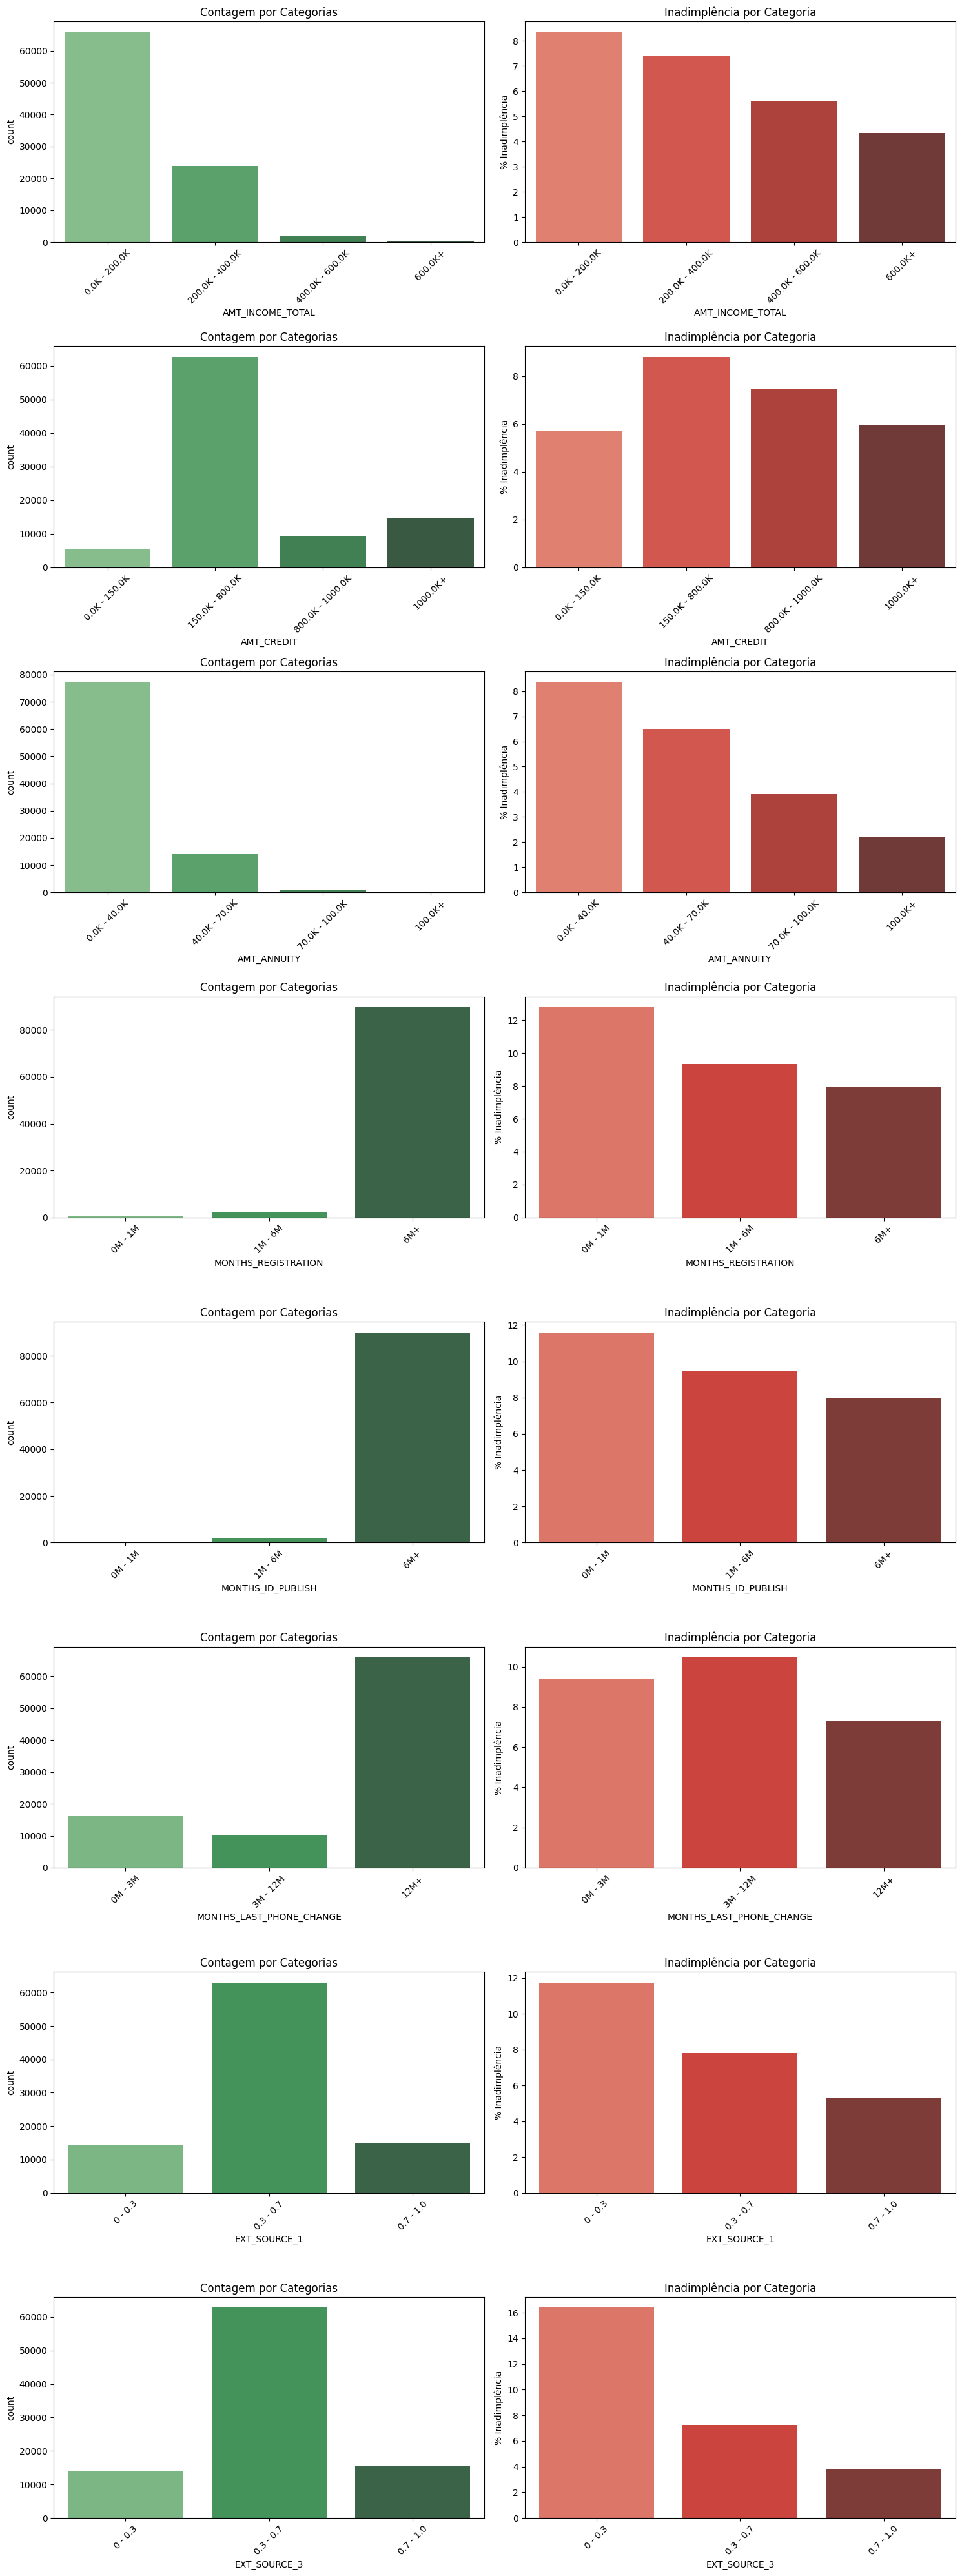

In [ ]:
bins = {
        'AMT_INCOME_TOTAL': [0, 200000, 400000, 600000, float('inf')]
        ,'AMT_CREDIT': [0, 150000, 800000, 1000000, float('inf')]
        ,'AMT_ANNUITY': [0, 40000, 70000, 100000, float('inf')]
        ,'MONTHS_REGISTRATION': [0, 1, 6, float('inf')]
        ,'MONTHS_ID_PUBLISH': [0, 1, 6, float('inf')]
        ,'MONTHS_LAST_PHONE_CHANGE': [0, 3, 12, float('inf')]
        ,'EXT_SOURCE_1': [0, 0.3, 0.7, 1.0]
        ,'EXT_SOURCE_3': [0, 0.3, 0.7, 1.0]
      }

labels = {
    'AMT_INCOME_TOTAL': [f'{bins["AMT_INCOME_TOTAL"][0]/1000}K - {bins["AMT_INCOME_TOTAL"][1]/1000}K',
                         f'{bins["AMT_INCOME_TOTAL"][1]/1000}K - {bins["AMT_INCOME_TOTAL"][2]/1000}K',
                         f'{bins["AMT_INCOME_TOTAL"][2]/1000}K - {bins["AMT_INCOME_TOTAL"][3]/1000}K',
                         f'{bins["AMT_INCOME_TOTAL"][3]/1000}K+'],
    'AMT_CREDIT': [f'{bins["AMT_CREDIT"][0]/1000}K - {bins["AMT_CREDIT"][1]/1000}K',
                    f'{bins["AMT_CREDIT"][1]/1000}K - {bins["AMT_CREDIT"][2]/1000}K',
                    f'{bins["AMT_CREDIT"][2]/1000}K - {bins["AMT_CREDIT"][3]/1000}K',
                    f'{bins["AMT_CREDIT"][3]/1000}K+'],
    'AMT_ANNUITY': [f'{bins["AMT_ANNUITY"][0]/1000}K - {bins["AMT_ANNUITY"][1]/1000}K',
                     f'{bins["AMT_ANNUITY"][1]/1000}K - {bins["AMT_ANNUITY"][2]/1000}K',
                     f'{bins["AMT_ANNUITY"][2]/1000}K - {bins["AMT_ANNUITY"][3]/1000}K',
                     f'{bins["AMT_ANNUITY"][3]/1000}K+'],
    'MONTHS_REGISTRATION': [f'{bins["MONTHS_REGISTRATION"][0]}M - {bins["MONTHS_REGISTRATION"][1]}M',
                             f'{bins["MONTHS_REGISTRATION"][1]}M - {bins["MONTHS_REGISTRATION"][2]}M',
                             f'{bins["MONTHS_REGISTRATION"][2]}M+'],
    'MONTHS_ID_PUBLISH': [f'{bins["MONTHS_ID_PUBLISH"][0]}M - {bins["MONTHS_ID_PUBLISH"][1]}M',
                           f'{bins["MONTHS_ID_PUBLISH"][1]}M - {bins["MONTHS_ID_PUBLISH"][2]}M',
                           f'{bins["MONTHS_ID_PUBLISH"][2]}M+'],
    'MONTHS_LAST_PHONE_CHANGE': [f'{bins["MONTHS_LAST_PHONE_CHANGE"][0]}M - {bins["MONTHS_LAST_PHONE_CHANGE"][1]}M',
                                 f'{bins["MONTHS_LAST_PHONE_CHANGE"][1]}M - {bins["MONTHS_LAST_PHONE_CHANGE"][2]}M',
                                 f'{bins["MONTHS_LAST_PHONE_CHANGE"][2]}M+'],
    'EXT_SOURCE_1': [f'{bins["EXT_SOURCE_1"][0]} - {bins["EXT_SOURCE_1"][1]}',
                      f'{bins["EXT_SOURCE_1"][1]} - {bins["EXT_SOURCE_1"][2]}',
                      f'{bins["EXT_SOURCE_1"][2]} - {bins["EXT_SOURCE_1"][3]}'],
    'EXT_SOURCE_3': [f'{bins["EXT_SOURCE_3"][0]} - {bins["EXT_SOURCE_3"][1]}',
                      f'{bins["EXT_SOURCE_3"][1]} - {bins["EXT_SOURCE_3"][2]}',
                      f'{bins["EXT_SOURCE_3"][2]} - {bins["EXT_SOURCE_3"][3]}']
}

columns_to_categorize = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'MONTHS_REGISTRATION',
                         'MONTHS_ID_PUBLISH', 'MONTHS_LAST_PHONE_CHANGE', 'EXT_SOURCE_1', 'EXT_SOURCE_3']


fig, axes = plt.subplots(len(columns_to_categorize), 2, figsize = (15, 5 * len(columns_to_categorize)))

for i, col in enumerate(columns_to_categorize):

    df_cur[f'{col}_CAT'] = pd.cut(df_cur[col], bins = bins[col], labels = labels[col], right = False)


    sns.countplot(data = df_cur, x = f'{col}_CAT', ax = axes[i, 0], palette = 'Greens_d')
    axes[i, 0].set_title(f'Contagem por Categorias')
    axes[i, 0].set_xlabel(f'{col}')
    axes[i, 0].tick_params(axis = 'x', rotation = 45)


    target_1_percentage = df_cur.groupby(f'{col}_CAT')['TARGET'].value_counts(normalize = True).mul(100).rename('percent').reset_index()
    target_1_percentage = target_1_percentage[target_1_percentage['TARGET'] == 1]

    sns.barplot(data = target_1_percentage, x = f'{col}_CAT', y = 'percent', ax = axes[i, 1], palette = 'Reds_d')
    axes[i, 1].set_title(f'Inadimplência por Categoria')
    axes[i, 1].set_xlabel(f'{col}')
    axes[i, 1].set_ylabel('% Inadimplência')
    axes[i, 1].tick_params(axis = 'x', rotation = 45)


plt.tight_layout()
plt.show()

Insights:

*   **AMT_INCOME_TOTAL:** quanto maior a faixa de renda anual na qual o proponente está inserido, menor o risco de inadimplência;

*   **AMT_CREDIT:** aqui verificamos que nos extremos dos montantes de crédito solicitado, moram as menores taxas de inadimplência. Já na faixas intermediárias (onde inclusive reside a maior frequência das solcitações), o risco já aumenta um pouco;

*   **AMT_ANNUITY:** o comportamento é bem linear na direção de redução da inadimplência conforme o valor da anuidade aumenta, porém com cada vez menos clientes em faixas maiores;

*   **MONTHS_REGISTRATION, MONTHS_ID_PUBLISH e MONTHS_LAST_PHONE_CHANGE:** quanto maior o tempo observado entre a data da solicitação e uma possível identificação de alteração de dados (registro, identificação, telefone, etc...);

*   **EXT_SOURCE_1 e EXT_SOURCE_3:** o risco de inadimplência diminui na direção do aumento do score. O comportamento é bem próximo nas duas variáveis (provavelmente há uma multicolinearidade entre elas), porém na EXT_SOURCE_3 percebe-se um melhor poder de discriminação do evento.



In [ ]:
df_vars['AMT_INCOME_TOTAL'] = df_cur['AMT_INCOME_TOTAL'].astype(int)
df_vars['AMT_CREDIT'] = df_cur['AMT_CREDIT'].astype(int)
df_vars['AMT_ANNUITY'] = df_cur['AMT_ANNUITY'].astype(int)
df_vars['MONTHS_REGISTRATION'] = df_cur['MONTHS_REGISTRATION'].astype(int)
df_vars['MONTHS_ID_PUBLISH'] = df_cur['MONTHS_ID_PUBLISH'].astype(int)
df_vars['MONTHS_LAST_PHONE_CHANGE'] = df_cur['MONTHS_LAST_PHONE_CHANGE'].astype(int)
df_vars['EXT_SOURCE_1'] = df_cur['EXT_SOURCE_1']
df_vars['EXT_SOURCE_3'] = df_cur['EXT_SOURCE_3']

Vamos agora avaliar que variáveis podemos agregar da base de empréstimos anteriores para melhorar nossa detecção da inadimplência:

In [ ]:
df_vars['AMT_PREV_LOAN'] = df_vars['SK_ID_CURR'].apply(lambda x: df_prev[df_prev['SK_ID_CURR'] == x]['SK_ID_CURR'].count())

df_vars['REP_PREV_LOAN'] = df_vars['SK_ID_CURR'].apply(lambda x: 1 if (df_prev[df_prev['SK_ID_CURR'] == x]['AMT_CREDIT'] > 0).any() else 0)

df_vars['CONTRACT_TYPE_PREV'] = df_vars['SK_ID_CURR'].apply(lambda x: df_prev[df_prev['SK_ID_CURR'] == x]['NAME_CONTRACT_TYPE'].iloc[0] if not df_prev[df_prev['SK_ID_CURR'] == x].empty else None)

df_vars['ANT_LOAN_FAST'] = df_vars['SK_ID_CURR'].apply(lambda x: 1 if not df_prev[df_prev['SK_ID_CURR'] == x].empty and (df_prev[df_prev['SK_ID_CURR'] == x]['MONTHS_TERMINATION'] < 12).any() else 0)

Conceitos das novas variáveis:



*   **AMT_PREV_LOAN:** traz o histórico de solicitações anteriores que o proponente possa ter realizado, contando a quantidade de vezes;

*   **REP_PREV_LOAN:** flag que verifica se já houve histórico de reprovação de solicitação anterior do proponente. Aqui, assumimos a premissa de que AMT_CREDIT = 0 significa que o empréstimo não foi aprovado;

*   **CONTRACT_TYPE_PREV:** se houve solicitação anterior, traz se o empréstimo foi em diretamente em dinheiro ou em rotativo;

*   **ANT_LOAN_FAST:** verifica se em caso de solicitação de empréstimo anterior, a atual está sendo feita em um intervalo de tempo muito curto (menor que 12 meses), buscano denotar um maior risco.



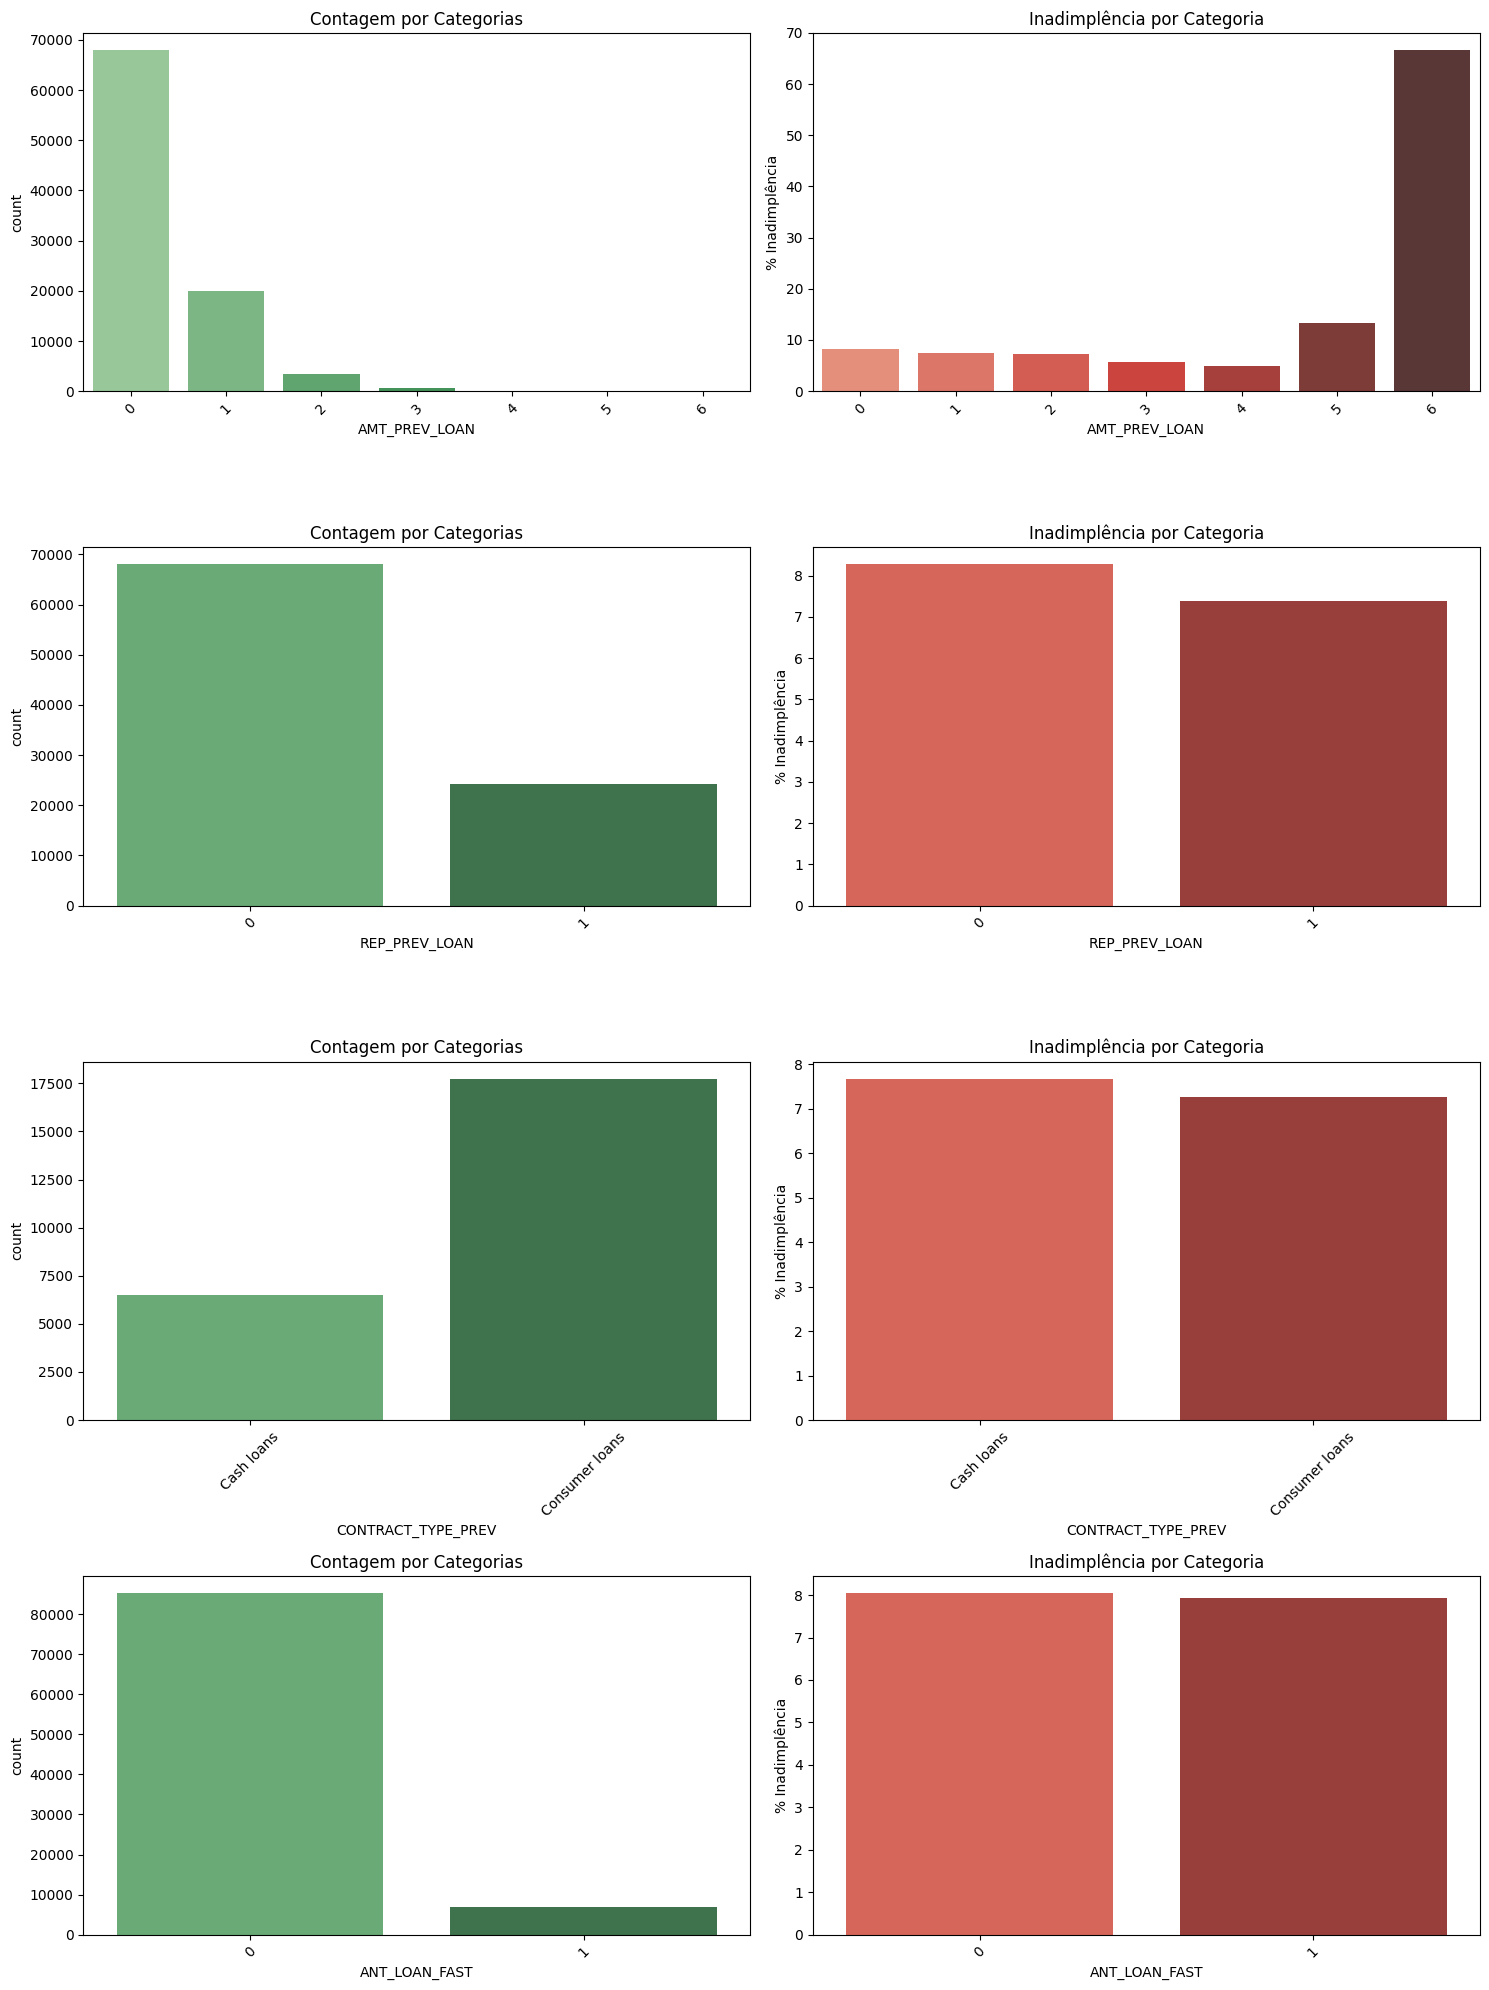

In [ ]:
variables = ['AMT_PREV_LOAN', 'REP_PREV_LOAN', 'CONTRACT_TYPE_PREV', 'ANT_LOAN_FAST']

fig, axes = plt.subplots(len(variables), 2, figsize = (15, 5 * len(variables)))

for i, var in enumerate(variables):

    sns.countplot(data = df_vars, x = var, ax = axes[i, 0], palette = 'Greens_d')
    axes[i, 0].set_title('Contagem por Categorias')
    axes[i, 0].tick_params(axis = 'x', rotation = 45)


    target_1_percentage = df_vars.groupby(var)['TARGET'].value_counts(normalize = True).mul(100).rename('percent').reset_index()
    target_1_percentage = target_1_percentage[target_1_percentage['TARGET'] == 1]

    sns.barplot(data = target_1_percentage, x = var, y = 'percent', ax = axes[i, 1], palette = 'Reds_d')
    axes[i, 1].set_title('Inadimplência por Categoria')
    axes[i, 1].set_ylabel('% Inadimplência')
    axes[i, 1].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()

Insights:

*   **AMT_PREV_LOAN:** a grande maioria está solicitando o empréstimo pela 1ª vez ou tem apenas uma recorrência, porém fica nítido que quanto maior o histórico mais risco de inadimplência é agregado;

*   **REP_PREV_LOAN:** as taxas de inadimplência entre os dois públicos (reprovados ou não) não apresenta diferenças significativas, embora a parcela com esse histórico seja menor que a aprovada;

*   **CONTRACT_TYPE_PREV:** a modalidade "Cash loans" se evidencia devido sua baixa frequência porém acompanhada de riscos de inadimplência no mesmo patamar das outras categorias;

*   **ANT_LOAN_FAST:** mesma observação da variável anterior, agora para a categoria de um novo empréstimo em curto intervalo de tempo.



### Análise de correlação entre as variáveis previamente selecionadas

Vamos categorizar as colunas pertinentes dentro do dataframe "df_vars" para então plotarmos um mapa de correlações

In [ ]:
df_vars['NAME_INCOME_TYPE'] = df_vars['NAME_INCOME_TYPE'].apply(lambda x: 1 if x in ['Pensioner', 'State servant'] else (2 if x == 'Commercial associate' else 3))

df_vars['NAME_HOUSING_TYPE'] = df_vars['NAME_HOUSING_TYPE'].apply(lambda x: 1 if x in ['Co-op apartment', 'Municipal apartment'] else (2 if x in ['Rented apartment', 'With parents'] else 3))

def categorize_occupation(occupation):
    if isinstance(occupation, str) and "staff" in occupation.lower():
        return 1
    elif isinstance(occupation, str) and occupation in ['Laborers', 'Waiters/barmen staff', 'Low-skill Laborers', 'Security staff', 'Cleaning staff', 'Drivers', 'Cooking staff','Realty agents', 'Sales staff']:
      return 2
    else:
        return 3

df_vars['OCCUPATION_TYPE'] = df_vars['OCCUPATION_TYPE'].apply(categorize_occupation)

df_vars['CONTRACT_TYPE_PREV'] = df_vars['CONTRACT_TYPE_PREV'].apply(lambda x: 1 if x in ['Cash loans'] else 2)

def categorize_amt_INCOME_TOTAL(amt_INCOME_TOTAL):
    if amt_INCOME_TOTAL <= 100000:
        return 1
    elif amt_INCOME_TOTAL > 100000 and amt_INCOME_TOTAL <= 300000:
      return 2
    elif amt_INCOME_TOTAL > 300000 and amt_INCOME_TOTAL <= 500000:
      return 3
    elif amt_INCOME_TOTAL > 500000 and amt_INCOME_TOTAL <= 1000000:
      return 4
    else:
        return 5

df_vars['AMT_INCOME_TOTAL'] = df_vars['AMT_INCOME_TOTAL'].apply(categorize_amt_INCOME_TOTAL)

def categorize_amt_credit(amt_credit):
    if amt_credit <= 100000:
        return 1
    elif amt_credit > 100000 and amt_credit <= 300000:
      return 2
    elif amt_credit > 300000 and amt_credit <= 500000:
      return 3
    elif amt_credit > 500000 and amt_credit <= 1000000:
      return 4
    else:
        return 5

df_vars['AMT_CREDIT'] = df_vars['AMT_CREDIT'].apply(categorize_amt_credit)


def categorize_age(age):
    if age <= 30:
        return 1
    elif age > 30 and age <= 45:
      return 2
    elif age > 45 and age <= 60:
      return 3
    else:
        return 4

df_vars['AGE'] = df_vars['AGE'].apply(categorize_age)


def categorize_amt_annuity(amt_annuity):
    if amt_annuity <= 10000:
        return 1
    elif amt_annuity > 10000 and amt_annuity <= 30000:
      return 2
    elif amt_annuity > 30000 and amt_annuity <= 50000:
      return 3
    elif amt_annuity > 50000 and amt_annuity <= 100000:
      return 4
    else:
        return 5


df_vars['AMT_ANNUITY'] = df_vars['AMT_ANNUITY'].apply(categorize_amt_annuity)


Com o nosso dataset previamente refinado, iremos agora verificar quais variáveis possuem maior correlação com o evento (TARGET) bem como, identificar possíveis multicolinearidades entre elas e, assim pensar em alguma estratégia de redução de dimensionalidade (se for o caso):

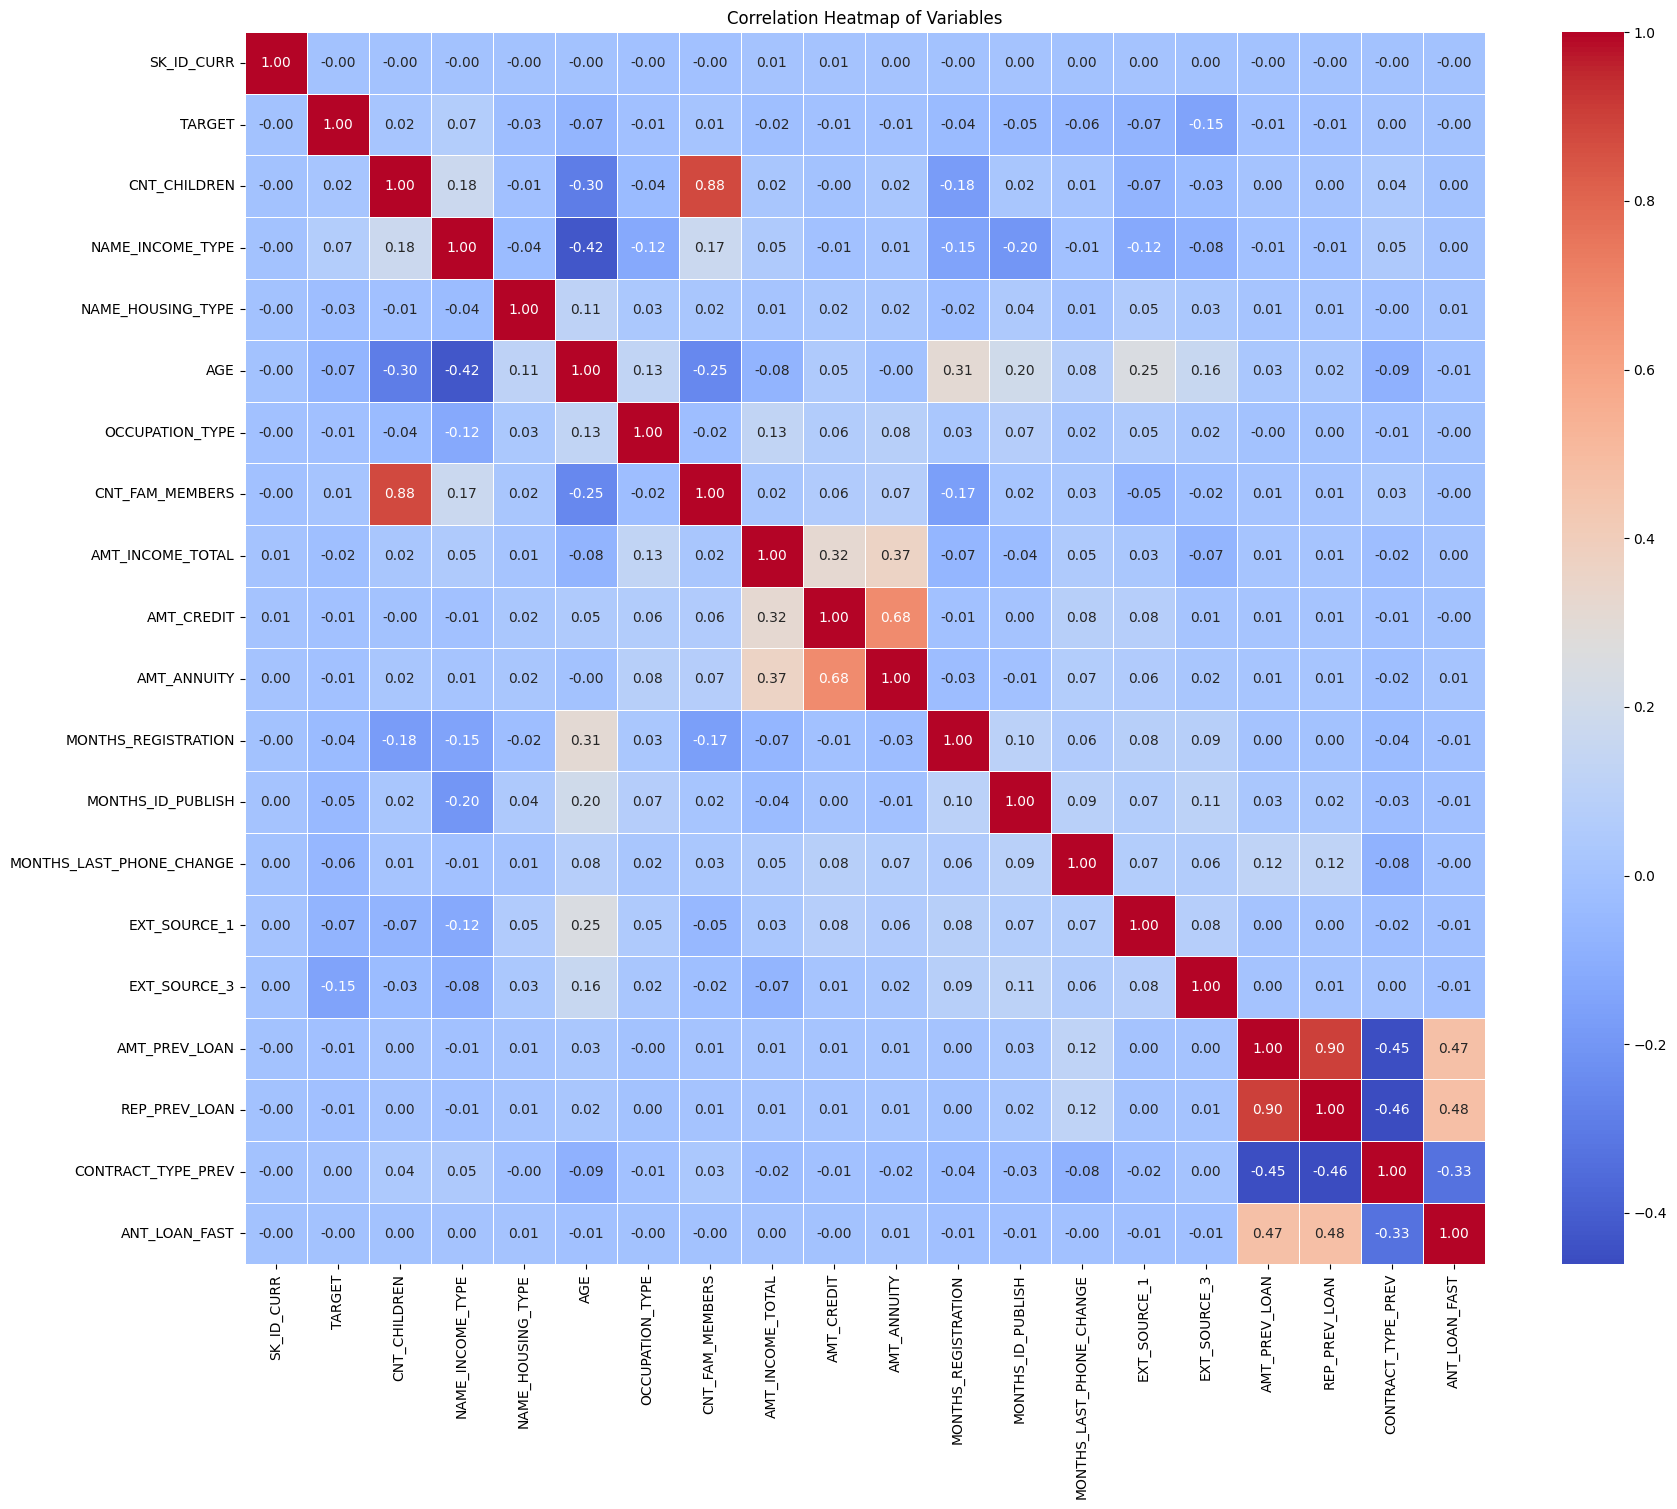

In [ ]:
corr = df_vars.corr()
plt.figure(figsize = (20, 16))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)
plt.title('Correlation Heatmap of Variables')
plt.show()


Infelizmente a análise por correlações não nos evidenciou variáveis tão satisfatória/fortemente correlacionadas ao evento TARGET. Portanto, para construir as políticas vamos nos basear nos insights descritos anteriormente ao longo do trabalho e tentar combinar variáveis com baixo alcance de proponentes e melhor discriminação para tentar alcançar o mais próximo possível os objetivos dos cenários.

### Políticas para CENÁRIO 01 (Redução de 10% na taxa de Inadimplência)

In [ ]:
df_filtered = df_vars[~(
                          (df_vars['EXT_SOURCE_3'] <= 0.3)
                        & (df_vars['AMT_INCOME_TOTAL'] <= 2)
                        & (
                            (df_vars['CNT_CHILDREN'] >= 3)
                            |
                            (df_vars['NAME_HOUSING_TYPE'] < 3)
                            |
                            (df_vars['CNT_FAM_MEMBERS'] > 3)
                            |
                             (df_vars['NAME_INCOME_TYPE']  < 2)
                            |
                             (df_vars['AGE'] < 2)
                            |
                             (df_vars['CONTRACT_TYPE_PREV'] == 1)
                            |
                             (df_vars['AMT_PREV_LOAN'] > 0)
                          )
                      )]


target_percentage_filtered = df_filtered['TARGET'].value_counts(normalize = True) * 100
percentage_target_1_filtered = target_percentage_filtered.get(1, 0)


removed_rows_percentage = (1 - len(df_filtered) / len(df_vars)) * 100

target_percentage = df_vars['TARGET'].value_counts(normalize = True) * 100

target_relative_reduction = (1 - percentage_target_1_filtered / target_percentage[1]) * 100


print(f"Taxa de Inadimplência atual: {target_percentage[1]:.2f}%")
print(f"Taxa de Inadimplência após aplicação da política: {percentage_target_1_filtered:.2f}%")
print(f"Redução na aprovação: {removed_rows_percentage:.2f}%")
print(f"Redução relativa na taxa de Inadimplência: {target_relative_reduction:.2f}%")

Taxa de Inadimplência atual: 8.04%
Taxa de Inadimplência após aplicação da política: 7.23%
Redução na aprovação: 9.11%
Redução relativa na taxa de Inadimplência: 10.00%


Política de reprovação resultante:

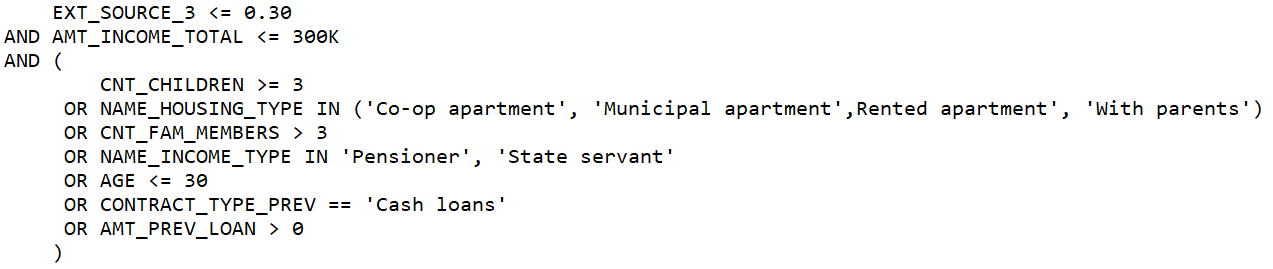

### Políticas para CENÁRIO 02 (Redução de 20% na taxa de Inadimplência)

In [ ]:
df_filtered = df_vars[~(
                          (df_vars['EXT_SOURCE_3'] <= 0.32)
                        & (df_vars['AMT_INCOME_TOTAL'] <= 4)
                        & (
                            (df_vars['CNT_CHILDREN'] >= 3)
                            |
                            (df_vars['NAME_HOUSING_TYPE'] < 3)
                            |
                            (df_vars['CNT_FAM_MEMBERS'] > 3)
                            |
                             (df_vars['NAME_INCOME_TYPE']  <= 2)
                            |
                             (df_vars['AGE'] < 2)
                            |
                             (df_vars['AGE'] > 3)
                            |
                             (df_vars['CONTRACT_TYPE_PREV'] == 1)
                            |
                             (df_vars['ANT_LOAN_FAST'] > 0)
                            |
                             (df_vars['EXT_SOURCE_1'] <= 0.4)
                            |
                             (df_vars['OCCUPATION_TYPE'] <= 2)
                          )
                      )]


target_percentage_filtered = df_filtered['TARGET'].value_counts(normalize = True) * 100
percentage_target_1_filtered = target_percentage_filtered.get(1, 0)


removed_rows_percentage = (1 - len(df_filtered) / len(df_vars)) * 100

target_percentage = df_vars['TARGET'].value_counts(normalize = True) * 100

target_relative_reduction = (1 - percentage_target_1_filtered / target_percentage[1]) * 100


print(f"Taxa de Inadimplência atual: {target_percentage[1]:.2f}%")
print(f"Taxa de Inadimplência após aplicação da política: {percentage_target_1_filtered:.2f}%")
print(f"Redução na aprovação: {removed_rows_percentage:.2f}%")
print(f"Redução relativa na taxa de Inadimplência: {target_relative_reduction:.2f}%")

Taxa de Inadimplência atual: 8.04%
Taxa de Inadimplência após aplicação da política: 6.45%
Redução na aprovação: 16.77%
Redução relativa na taxa de Inadimplência: 19.72%


Política de reprovação resultante:

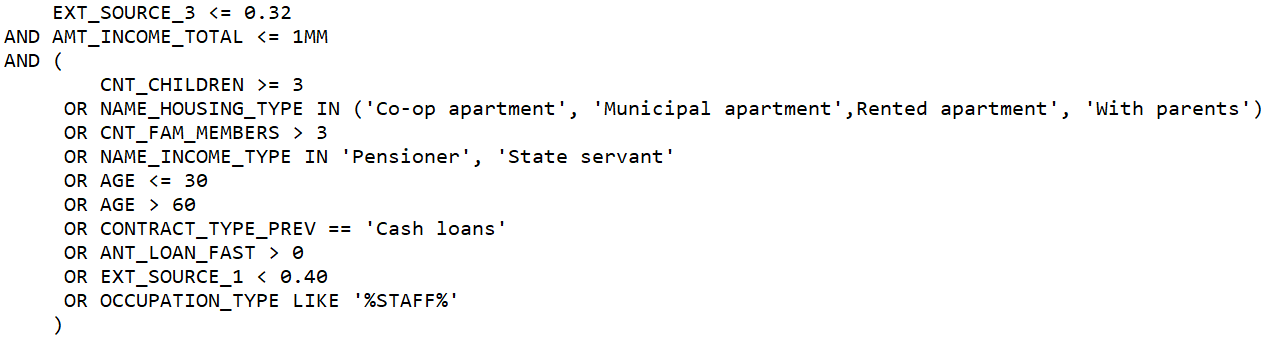

## Comentários finais


*   Do ponto de vista de qualidade de dados, a base de empréstimos atuais se apresentou bem formatada necessitando de pouco esforço de estratégias de limpeza/complemento. Porém, a base de empréstimos anteriores estava em situação oposta, o que acabou por não contribuir muito com a análise devido a necessidade de muitas remoções de registros;

*   Talvez a dificuldade relatada no ponto anterior tenha sido determinante para que, mesmo combinando as duas bases não houveram variáveis com alta correlação ao evento de inadimplência. Para contornar isso, necessitaríamos de mais registros ou até mesmo de mais variáveis acerca das solicitações disponíveis. Assim, com possíveis correlações mais satisfatórias, análises de WoE's (redução de dimensionalidade das variáveis) e IV poderiam ter sido utilizadas para chegarmos mais facilmente às melhores variáveis para construir os insights;

*   Apesar das dificuldades, conseguimos atingir os objetivos de cada cenário. As políticas propostas ficaram ligeiramente complexas (muitas combinações de critérios) porém, tudo devido às dificuldades já citadas. De modo que, precisamos acompanhar temporalmente para avaliar a estabilidade delas e, tentar implementar o quanto antes as sugestões do ponto anterior.